# Evaluation script for RTC

With this script, you can evaluate the effect of RTC by creating similar plots to `tng_rtc/docs/media/rtc_effect_visualization.svg`.

For that, **first** run ```uv sync --extra base``` in your command line and use the generated `.venv`-environment for this notebook.

In [ ]:
# Set the current working folder to the base of this repo
%cd /path/to/this/repo
%pwd

/home/koenig-karl/innovation-hacking/robotics/to_share/Isaac-GR00T


/home/koenig-karl/innovation-hacking/robotics/to_share/Isaac-GR00T/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/koenig-karl/innovation-hacking/robotics/to_share/Isaac-GR00T'

## Setup

First, the necessary packages are imported.

In [2]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt

from tng_rtc.rtc_policy import RTCGr00tPolicy
from tng_rtc.extended_data_config import DATA_CONFIG_MAP

/home/koenig-karl/innovation-hacking/robotics/to_share/Isaac-GR00T/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 23:54:40.253801: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 23:54:40.274183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-29 23:54:40.274212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has al

Then the model used in this evaluation script is loaded. For that, set your model in the `MODEL_PATH`-variable, your embodiment-tag in the `EMBODIMENT_TAG`-variable and your data config in the `DATA_CONFIG`-variable. Note: You can achieve better results by using a model with bigger action horizon, e.g. 40.

In [3]:
MODEL_PATH = "nvidia/GR00T-N1.5-3B" # Path to a huggingface model or a local model
EMBODIMENT_TAG = "gr1"
DATA_CONFIG = "large_horizon_fourier_gr1_arms_only"

data_config = DATA_CONFIG_MAP[DATA_CONFIG]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

ACTION_CHUNK_SIZE = len(data_config.action_indices)

policy = RTCGr00tPolicy(
        model_path=MODEL_PATH,
        modality_config=modality_config,
        modality_transform=modality_transform,
        embodiment_tag=EMBODIMENT_TAG,
        denoising_steps=4,
    )

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 204984.78it/s]


Loading pretrained dual brain from /home/koenig-karl/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/869830fc749c35f34771aa5209f923ac57e4564e
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/koenig-karl/.cache/huggingface/hub/models--nvidia--GR00T-N1.5-3B/snapshots/869830fc749c35f34771aa5209f923ac57e4564e


/home/koenig-karl/innovation-hacking/robotics/to_share/Isaac-GR00T/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5090 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


Tune backbone llm: False
Tune backbone visual: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True
Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 25.48it/s]

Tune backbone llm: False
Tune backbone visual: True
Tune action head projector: True
Tune action head diffusion model: True
Policy: Recreating action head with action_horizon 40 (was 16)


Total number of DiT parameters:  550386688
Total number of SelfAttentionTransformer parameters:  201433088
Tune action head projector: True
Tune action head diffusion model: True
Set action denoising steps to 4


## Evaluation

First, an action chunk is randomly generated which simulates the trajectory a robot is executing right now (later plotted with a **black** line).

In [4]:
prev_action_numpy = np.zeros((1, ACTION_CHUNK_SIZE, 32))

x = np.linspace(0, 2 * np.pi, ACTION_CHUNK_SIZE)

for i in range(32):
    curve = 0.5 * np.sin(x + i / 3.0) + np.random.normal(0, 0.05, ACTION_CHUNK_SIZE)
    prev_action_numpy[0, :, i] = curve
prev_action = torch.tensor(prev_action_numpy, device="cuda", dtype=torch.bfloat16)

Second, an observation is randomly generated. This observation is used for action chunk inference.

In [5]:
current_observation = {
    "video.ego_view": np.random.randint(0, 256, (1, 256, 256, 3), dtype=np.uint8),
    "state.right_arm": np.expand_dims(np.random.rand(7), axis=0),
    "state.left_arm": np.expand_dims(np.random.rand(7), axis=0),
    "state.left_hand": np.expand_dims(np.random.rand(6), axis=0),
    "state.right_hand": np.expand_dims(np.random.rand(6), axis=0),
    "annotation.human.task_description": ["{'Make the chicken dance.'}"],
}

For this evaluation, we randomly generate a fixed noised action chunk which will be used by the **get_realtime_action**-methods, so that every action prediction routine uses the same noised action chunk in the beginning.

In [6]:
start_actions = torch.randn(
    size=(1, ACTION_CHUNK_SIZE, 32),
    dtype=torch.bfloat16,
    device="cuda",
)

Here, a raw action chunk is inferred by using the default inference without RTC (later plotted with a **red** line) (Note: executing `get_realtime_action` without `A_prev` set is like executing the default inference without RTC). For that, the `start_actions` are provided so that these are used as the noised action chunk in the beginning.

In [7]:
raw_action = np.array(policy.get_realtime_action(copy.deepcopy(current_observation), start_actions=copy.deepcopy(start_actions)).cpu())

Then here, first an action chunk, `prev_action_chunk`, is defined containing actions the action chunk created with RTC should be aligned to. Then an action chunk using RTC is inferred (later plotted with a **green** line). Here you can set the `max_guidance_weight` (default: 5) and choose the `weight_function` (default: "exp", available: ["linear", "exp", "ones", "zeros"]) used by RTC.

In [8]:
prev_action_chunk = prev_action[:, :int(0.75 * ACTION_CHUNK_SIZE), :]
zeros = torch.zeros(1, ACTION_CHUNK_SIZE - int(0.75 * ACTION_CHUNK_SIZE), 32, dtype=prev_action.dtype, device=prev_action.device)
prev_action_chunk = torch.cat([prev_action_chunk, zeros], dim=1)

In [9]:
rtc_action = np.array(policy.get_realtime_action(copy.deepcopy(current_observation), prev_action_chunk, int(0.25 * ACTION_CHUNK_SIZE), ACTION_CHUNK_SIZE - int(0.7 * ACTION_CHUNK_SIZE), ACTION_CHUNK_SIZE, max_guidance_weight=5, weight_function="exp", start_actions=copy.deepcopy(start_actions)).cpu())

Now the plots are generated. More explanaitions to the plots can be found in the docu (`tng_rtc/docs/rtc_evaluation.md`).

/tmp/ipykernel_1765386/3424072984.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


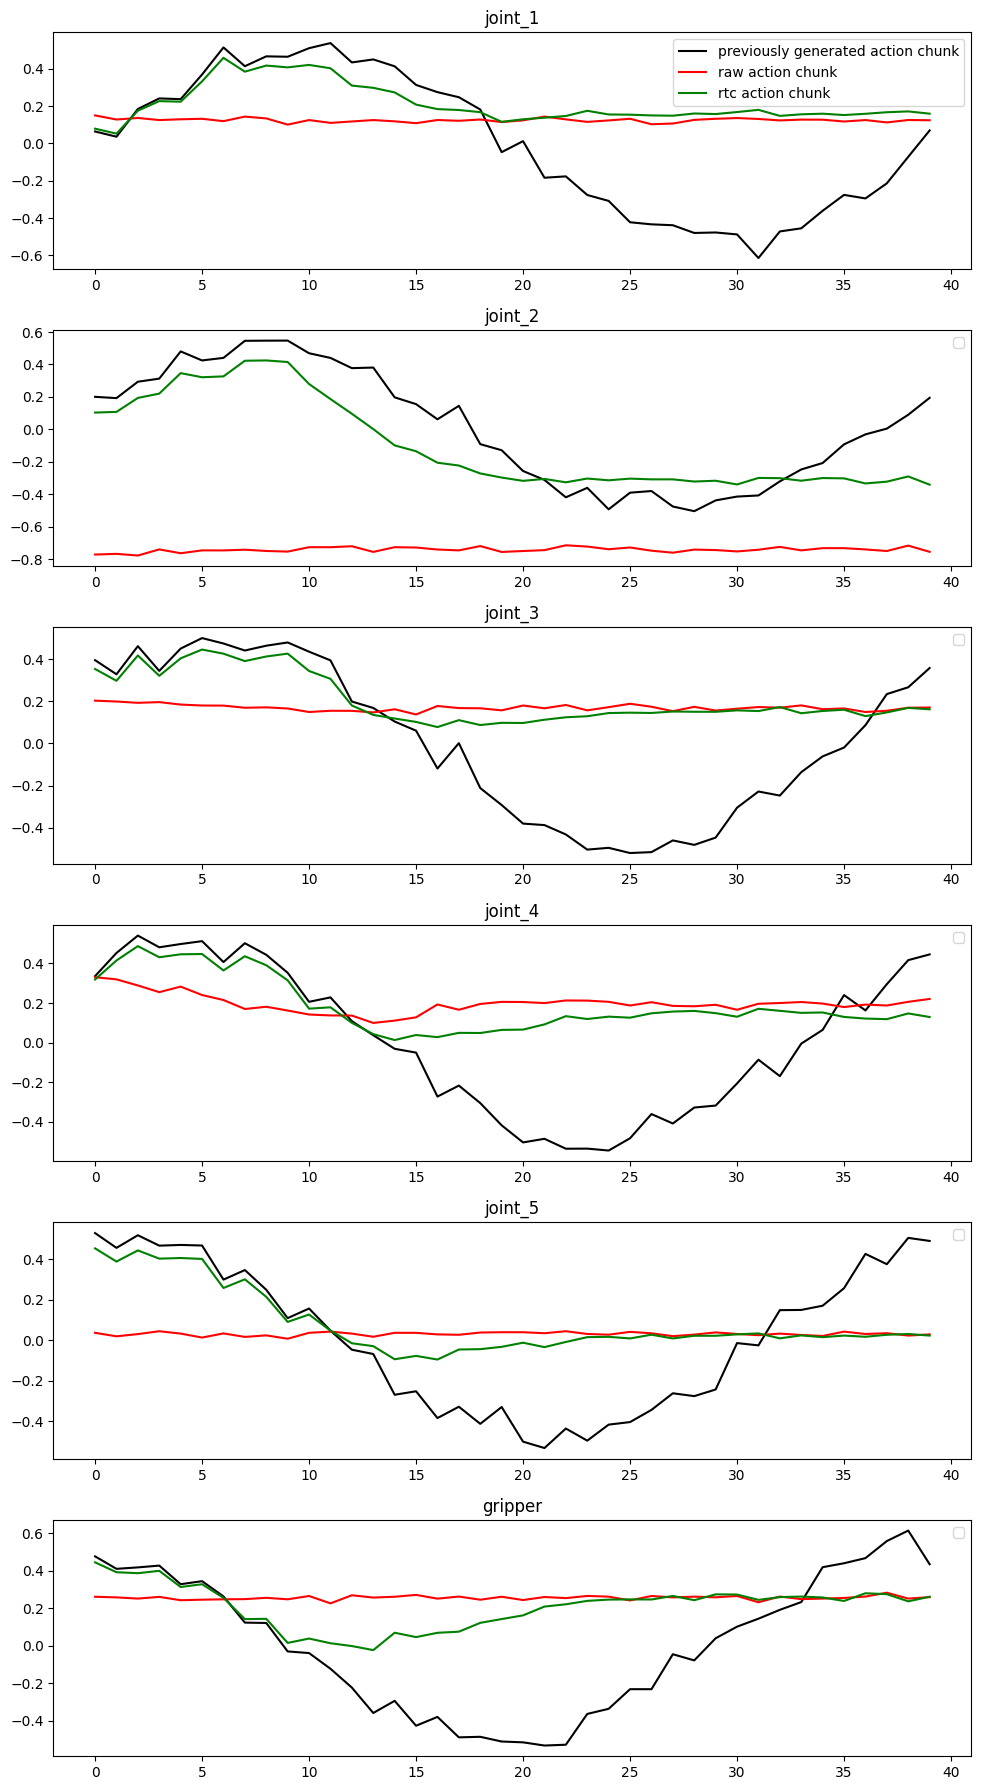

In [10]:
MOTOR_NAMES = [
    "joint_1",
    "joint_2",
    "joint_3",
    "joint_4",
    "joint_5",
    "gripper"
]

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 3 * 6))

for i, ax in enumerate(axes):
    if i == 0:
        ax.plot(prev_action_numpy[0][:, i], label="previously generated action chunk", color="black")
        ax.plot(raw_action[0][:, i], label="raw action chunk", color="red")
        ax.plot(rtc_action[0][:, i], label="rtc action chunk", color="green")
    else:
        ax.plot(prev_action_numpy[0][:, i], color="black")
        ax.plot(raw_action[0][:, i], color="red")
        ax.plot(rtc_action[0][:, i], color="green")
    ax.set_title(MOTOR_NAMES[i])
    ax.legend()

plt.tight_layout()

plt.show()